## DecisionTree

### ID3算法

ID3算法是一种贪心算法，用来构造决策树ID3决定哪些属性如何是最好的。一个统计特性,被称为信息增益,使用熵得到给定属性衡量培训例子带入目标类分开。信息增益最高的信息(信息是最有益的分类)被选择

#### 信息滴

l被称为不确定性函数，代表事件的信息量。log表示取对数。假定对于一个信源，其发生各种事件是相互独立的，并且其值具有可加性。因此使用log函数。可见，发生的概率越大，其不确定性越低。信息熵: 
$$  l(x_i) = - log_2p(x_i)$$

考虑到信源的所有可能发生的事件，假设其概率为p1,p2,...,pi，则可以计算其平均值(数学期望)，该值被称为信息熵或者经验熵。涵义即为：一个信源的平均不确定性，或者一个信源的不确定性期望。用公式表示为:
$$  H = -\sum_{i=1}^n p(x_i)log_2p(x_i)$$

#### 信息增益

| OUTLOOK | Temperature | huimidity | play? |
| ------- | ----------- | --------- | ----- |
| sunny   | hot         | high      | no    |
| sunny   | mild        | normal    | no    |
| rain    | mild        | high      | yes   |
| rain    | cool        | high      | no    |

假设要计算以上的按OUTLOOK特征划分时候的信息增益值
1. 未划分时play的信息滴为：
$$ H(S) = -\frac{3}{4}log_2\frac{3}{4} - -\frac{1}{4}log_2\frac{1}{4}=0.811$$
2. 按特征OUTLOOK划分时候play：
$$ H(sunny) = -\frac{2}{2}log_2\frac{2}{2}=0$$
$$ H(rain) = -\frac{1}{2}log_2\frac{1}{2}-\frac{1}{2}log_2\frac{1}{2}=1$$
$$ H(S|T) = -\frac{1}{2}\cdot0 + \frac{1}{2}\cdot1 $$
3. 信息增益：
$$ IG(T) = H(S) - H(S|T) $$
如果信息增益越大，那么就是指分完之后的信息熵越小，那也就意味着分完之后的数据趋向于有序，而越有序的数据，意味着我们能更好地预测数据

### 算法构建

用信息增益来选择最佳划分,选择信息增益值最大的特征来划分

In [35]:
from collections import Counter
from math import log
class Decision_Tree:
    def __init__(self, dataSet, feature_labels):
        self.dataSet = dataSet
        self.labels = feature_labels
        self.my_tree = self.__internal_bulid_tree(self.dataSet, self.labels)
        
    #计算数据的香浓滴大小
    def __calcu_Shannon(self, dataset):   
        data_vec = [a[-1] for a in dataset] #获取数据表中最后一列
        num = len(data_vec)
        dataset_count = Counter(data_vec) #获取每个事件的频率，用以计算概率

        shannon = 0
        for key, item in dataset_count.items():
            prob = float(item)/ num
            shannon -= prob * log(prob, 2)
        return shannon  
    
    #按指定特征axis的value划分数据用以计算信息增益
    def __split_dataset(self, dataset, axis, value):
        subdataset = []
        for feature in dataset:
            if feature[axis]== value:
                subfeature = feature[:axis]
                subfeature.extend(feature[axis+1:])
                subdataset.append(subfeature)
        return subdataset
    
    def __choose_best_feature(self, dataset):
        num_feature = len(dataset[0]) - 1
        base_entropy = self.__calcu_Shannon(dataset)
        best_info_gain = 0.0
        best_feature = -1
        len_dataset = len(dataset)
        #计算每一个特征的信息增益
        for i in range(num_feature):
            feature_list = [a[i] for a in dataset]
            uniquevals = set(feature_list)
            new_entropy = 0.0 #当前 H(S|T)      
            #计算H(S|T)
            for value in uniquevals:
                subdataset = self.__split_dataset(dataset, i, value)
                prob = len(subdataset) / len_dataset
                new_entropy += prob * self.__calcu_Shannon(subdataset)
            info_gain  = base_entropy - new_entropy
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_feature = i       
        return best_feature
    
    def __internal_bulid_tree(self, dataset, feature_labels):
        classlist = [a[-1] for a in dataset]
        #当所有分类都属于一个类别时，终止递归，返回叶节点
        if classlist.count(classlist[0]) == len(classlist):
            return classlist[0]
        #当没有特征时，返回叶节点中出现次数最多的那个节点
        if len(dataset[0]) == 1:
            count_most = Counter(classlist)
            count_most = sorted(count_most.items(), key = lambda x:x[1], reverse=True)
            return count_most[0][0] 
        
        best_feature  = self.__choose_best_feature(dataset)

        best_feature_label = feature_labels[best_feature]
        my_tree = {best_feature_label: {}}
        feature_vals = [a[best_feature] for a in dataset]
        uniquevals = set(feature_vals) 

        #del(feature_labels[best_feature])
        sublabels = [label for i,label in enumerate(feature_labels) if i != best_feature]    
        
        for value in uniquevals:
            my_tree[best_feature_label][value] = self.__internal_bulid_tree\
            (self.__split_dataset(dataset, best_feature, value), sublabels)
            
        return my_tree
    
    #递归在intree里面查询testVec所属分类
    def __internal_classify(self, intree, labels, testVec):
        firststr = list(intree.keys())[0]
        second_dict = intree[firststr]
        feature_index = labels.index(firststr) #获取firststr特征值属于labels的哪一列
        
        for key in second_dict.keys():
            if key == testVec[feature_index]:
                if type(second_dict[key]).__name__ == 'dict':
                    classlabel = self.__internal_classify(second_dict[key], labels, testVec)
                else:
                    classlabel = second_dict[key]
        return classlabel
    def classify(self, testVec):
        label = self.__internal_classify(self.my_tree, self.labels, testVec)
        return label

In [36]:
dataSet = [[1, 1, 'yes'],[1, 1, 'yes'], [1, 0, 'no'],[0, 1, 'no'],[0, 1, 'no']]
labels = ['no surfacing','flippers']

In [41]:
my_tree = Decision_Tree(dataSet,labels)

In [42]:
my_tree.classify([1,1])

'yes'

In [176]:
a = [1,2]

In [177]:
a[:0]+a[1:]

[2]

In [125]:
tree['11'][2] = 4

**思考：**在本次例子中tree是{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}这种形式的结构

1. 故上述代码的都是基于该种结构来实现。
2. 可不可以换一种结构来保存tree，使得代码更加简洁，易懂？？
```python
{'no surfacing': [['no', 1], ['flipper', 0]],
         'flipper': [['no', 1], ['yes', 1]]
}
```
3. 能否用上述结构？
4. 不能！因为不能flipper下的节点在该种结构无法保证是哪一层的，如果要使用，需要做类似ruxi

### 用matplotlib绘制决策树

In [47]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['SimHei']
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args, fontsize=14)
    
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30, fontsize=14)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white', figsize=(10,10))
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no', 2:'maybe'}}}}
                  ]
    return listOfTrees[i]
#thisTree = retrieveTree(0)
#createPlot(thisTree)

In [112]:
thistree = retrieveTree(1)

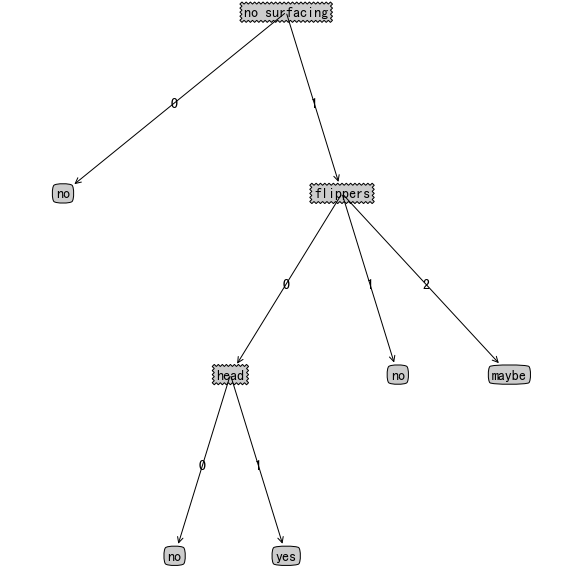

In [113]:
createPlot(thistree)

## 使用sklearn模块来实现决策树

In [129]:
from sklearn import tree

In [130]:
>>> X = [[0, 0], [1, 1]]
>>> Y = [0, 1]
>>> clf = tree.DecisionTreeClassifier()
>>> clf = clf.fit(X, Y)

In [131]:
clf.predict([[2., 2.]])

array([1])

In [142]:
#dataSet = [[1, 1, 'yes'],[1, 1, 'yes'], [1, 0, 'no'],[0, 1, 'no'],[0, 1, 'no']]
#labels = ['no surfacing','flippers']
X = [[1, 1],[1, 1], [1, 0],[0, 1],[0, 1]] #对应决策
y = [1,1,0,0,0]#对应分类结果，比如'yes','no'
clf = tree.DecisionTreeClassifier()

In [143]:
clf = clf.fit(dataSet, labels)

[Text(133.92000000000002, 181.2, 'X[0] <= 0.5\ngini = 0.48\nsamples = 5\nvalue = [3, 2]'),
 Text(66.96000000000001, 108.72, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(200.88000000000002, 108.72, 'X[1] <= 0.5\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(133.92000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(267.84000000000003, 36.23999999999998, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]')]

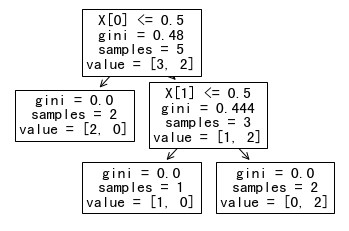

In [144]:
tree.plot_tree(clf)

In [145]:
>>> from sklearn.datasets import load_iris
>>> from sklearn import tree
>>> iris = load_iris()
>>> clf = tree.DecisionTreeClassifier()
>>> clf = clf.fit(iris.data, iris.target)

## 使用决策树预测隐形眼镜类型

In [43]:
with open('lenses.txt') as f:
    lensens =[line.strip().split('\t') for line in f.readlines()]
lenses_label = ['age', 'prescript', 'astigmatic', 'tearRate']

In [44]:
my_decision_tree = Decision_Tree(lensens, lenses_label)

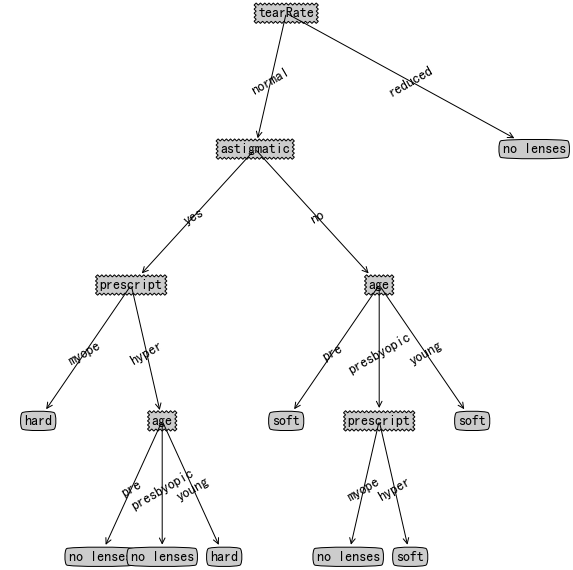

In [48]:
createPlot(my_decision_tree.my_tree)